In [1]:
import sys
sys.path.append('../../code/')

In [2]:
%load_ext autoreload
%autoreload 2

from libs import io
from libs import constants
from libs import vis

from libs.metrics import aggregators

from libs.visuals import gridcons
from libs.visuals import gridbar

Available LLMs: (24): llama-3.3-8b llama-4-scout llama-4-mav gpt-oss-20b gpt-oss-120b qwen3-8b qwen3-14b qwen3-32b qwen3-30b-a3b-2507 qwen3-235b-a22b-2507 gemma-3-12b gemma-3-27b mistral-small-3.2-24b mistral-medium-3 llama-3.1-70b llama-3.3-70b llama-3.1-405b grok-4-fast deepseek-chat-v3.1 deepseek-r1-0528 gemini-2.5-flash gemini-2.5-flash-grounded gemini-2.5-pro gemini-2.5-pro-grounded


/home/espinl/.conda/envs/py311_llmscholar/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

In [3]:
BENCHMARKS_PATH = '../../results/interventions/benchmarks/'

PLOTS_PATH = '../../results/interventions/plots'
TABLES_PATH = '../../results/interventions/tables'
LATEX_PATH = '../../results/interventions/latex'

io.validate_path(PLOTS_PATH)
io.validate_path(TABLES_PATH)
io.validate_path(LATEX_PATH)

## Data

In [4]:
files = io.get_files(BENCHMARKS_PATH, 'per_attempt_*.csv')
df_per_attempt_all = io.pd.concat([io.read_csv(fn, index_col=0, low_memory=False) for fn in files], ignore_index=True)
df_per_attempt_all.shape

(575005, 15)

In [5]:
PREFIX = 'infrastructure'
# filtering out interventions (biased prompts and rag)
query_infra = "task_name != @constants.EXPERIMENT_TASK_BIASED_TOP_K and grounded == False"
df_per_attempt = df_per_attempt_all.query(query_infra).copy()
df_per_attempt.shape

(337175, 15)

In [6]:
df_models_metadata = io.pd.DataFrame(constants._llm_metadata.values())
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.model.str.split('/').str[-1].str.replace('-instruct', '').str.replace('-it', '')
df_models_metadata.loc[:, 'model_access'] = df_models_metadata.model.apply(lambda x: 'propietary' if 'gemini' in x else 'open')
df_models_metadata.loc[:, 'model_size'] = df_models_metadata['class'].apply(lambda x: x.split(' ')[0])
df_models_metadata.loc[:, 'model_class'] = df_models_metadata.reasoning.apply(lambda x: 'R' if x else 'NR')
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.apply(lambda row: f"{row.model_name}-grounded" if row.grounded == True else row.model_name, axis=1)
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.apply(lambda row: 'llama-4-mav' if row.model_name =='llama-4-maverick' else row.model_name, axis=1)
df_models_metadata.model_name = df_models_metadata.model_name.apply(lambda x: 'llama-3.3-8b' if x == 'llama-3.1-8b' else x)
df_models_metadata.shape


(24, 26)

# Plots

In [7]:
vis.sns_reset()
vis.sns_paper_style(font_scale=constants.FONT_SCALE)

## Model group

In [8]:
df_summary_infrastructure_group = io.pd.DataFrame()
for group in constants.BENCHMARK_MODEL_GROUPS:
    groupby = [group, 'metric_name']
    per_group = aggregators.aggregate_per_group(df_per_attempt, groupby, alpha=0.05, metric_value_col='metric_value', metric_name_col='metric_name')
    per_group.rename(columns={group: 'model_kind'}, inplace=True)
    per_group.loc[:, 'model_group'] = group
    cols_order = ['model_group','model_kind']
    cols_order.extend(['n','metric_name','mean','std','median','sum','ci','ci_low','ci_high'])
    per_group = per_group[cols_order]
    df_summary_infrastructure_group = io.pd.concat([df_summary_infrastructure_group, per_group], axis=0, ignore_index=True)
df_summary_infrastructure_group.shape

(144, 11)

In [9]:
df_summary_infrastructure_group.head(5)

,model_group,model_kind,n,metric_name,mean,std,median,sum,ci,ci_low,ci_high
0,model_access,open,17318,connectedness,0.112130,0.168434,0.037521,1941.871840,0.002509,0.109621,0.114639
1,model_access,open,17315,connectedness_density,0.114595,0.142873,0.083333,1984.210053,0.002128,0.112467,0.116723
2,model_access,open,17318,connectedness_ncomponents,0.858495,0.175018,0.916667,14867.415828,0.002607,0.855888,0.861102
3,model_access,open,17318,connectedness_norm_entropy,0.887870,0.168434,0.962479,15376.128160,0.002509,0.885361,0.890379
4,model_access,open,335,consistency,0.309240,0.228521,0.275098,103.595311,0.024560,0.284680,0.333800


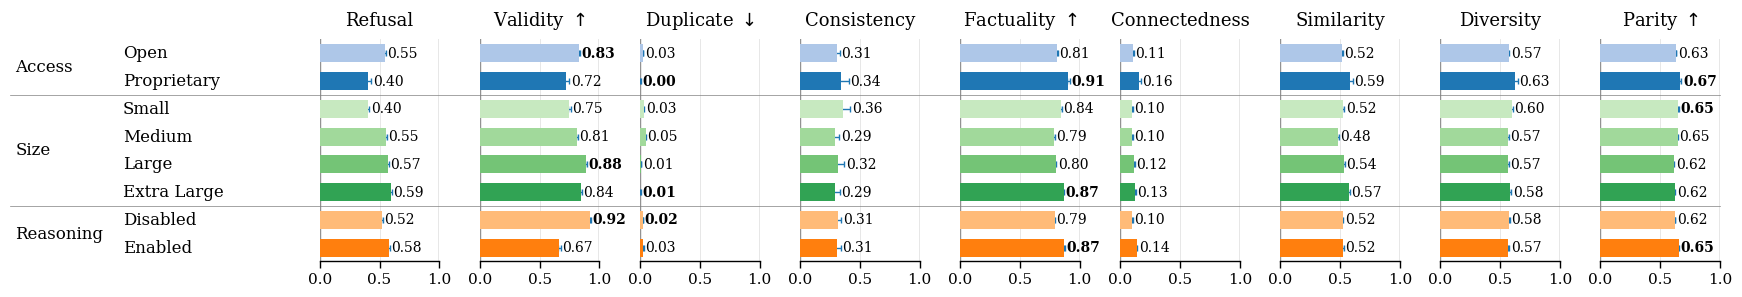

In [10]:

index = ['model_group','model_kind']
group_order = constants.BENCHMARK_MODEL_GROUPS
index_order = [(group_name,group) for group_name, group_list in constants.BENCHMARK_MODEL_GROUP_ORDER_WITHIN_GROUP.items() for group in group_list]
row_color_map = {(group_name,group):gridcons.GROUP_COLORS[group_name][i] for group_name, group_list in constants.BENCHMARK_MODEL_GROUP_ORDER_WITHIN_GROUP.items() for i, group in enumerate(group_list)}

index_label_maps = {
    1: constants.BENCHMARK_MODEL_GROUP_LABEL_MAP
}

values = (
    df_summary_infrastructure_group.pivot(index=index, columns='metric_name', values='mean')
)

ci_low = (
    df_summary_infrastructure_group.pivot(index=index, columns='metric_name', values='ci_low')
)

ci_high = (
    df_summary_infrastructure_group.pivot(index=index, columns='metric_name', values='ci_high')
)

width_ratios = gridbar.width_ratios_for_split(k_panels=len(gridcons.PANELS_METRICS), bars_share=0.8, panel_ratio=0.2)

fig = gridbar.plot_metric_grid_from_pivot(
    values,
    panels=gridcons.PANELS_METRICS_GROUPS,
    ci_low=ci_low,
    ci_high=ci_high,
    highlight_rules=constants.BENCHMARK_METRIC_HIGHLIGHT_RULES,
    layout=gridbar.LayoutSpec(figsize=(18, 3), wspace=0.30, separator_lw=0.5, width_ratios=width_ratios),
    style=gridbar.StyleSpec(bar_height=0.65, title_fontsize=13, label_fontsize=12, tick_fontsize=11, value_fontsize=10, x_vlines_lw=1.0),
    xlim=(0, 1),
    xticks=[0, 0.5, 1.0],
    row_color_map=row_color_map,
    index_order = index_order,
    index_label_maps=index_label_maps,
    group_label_map=constants.BENCHMARK_MODEL_GROUPS_LABEL_MAP
)

fn = io.path_join(PLOTS_PATH, f'{PREFIX}_by_model_group.pdf')
if fn is not None:
    fig.savefig(fn, dpi=constants.FIG_DPI, bbox_inches='tight')

gridbar.plt.show()
gridbar.plt.close()



## Model

In [11]:
df_summary_per_model = io.pd.DataFrame()
groupby = ['model', 'metric_name']
df_summary_per_model = aggregators.aggregate_per_group(df_per_attempt, groupby, alpha=0.05, metric_value_col='metric_value', metric_name_col='metric_name')
df_summary_per_model.loc[:, 'metric_group'] = df_summary_per_model.metric_name.apply(lambda x: x.split('_')[0])
df_summary_per_model.loc[:, 'metric_name_short'] = df_summary_per_model.metric_name.apply(lambda x: x.split('_')[-1])

# augment with metadata
df_models_metadata = io.pd.DataFrame(constants._llm_metadata.values())
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.model.str.split('/').str[-1].str.replace('-instruct', '').str.replace('-it', '')
df_models_metadata.loc[:, 'model_access'] = df_models_metadata.model.apply(lambda x: 'proprietary' if 'gemini' in x else 'open')
df_models_metadata.loc[:, 'model_size'] = df_models_metadata['class'].apply(lambda x: x.split(' ')[0])
df_models_metadata.loc[:, 'model_class'] = df_models_metadata.reasoning.apply(lambda x: 'reasoning' if x else 'non-reasoning')
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.apply(lambda row: f"{row.model_name}-grounded" if row.grounded == True else row.model_name, axis=1)
df_models_metadata.loc[:, 'model_name'] = df_models_metadata.apply(lambda row: 'llama-4-mav' if row.model_name =='llama-4-maverick' else row.model_name, axis=1)
df_models_metadata.loc[:, 'model_provider'] = df_models_metadata.model_name.str.split('-').str[0]
df_models_metadata.loc[:, 'model_color'] = df_models_metadata.model_provider.map(constants.LLM_CLASS_COLORS)
df_models_metadata.model_name = df_models_metadata.model_name.apply(lambda x: 'llama-3.3-8b' if x == 'llama-3.1-8b' else x)
df_summary_per_model = df_summary_per_model.set_index('model').join(df_models_metadata.set_index('model_name')[constants.BENCHMARK_MODEL_GROUPS+['model_color']]).reset_index()

df_summary_per_model.head(2)

,model,metric_name,n,mean,std,median,sum,ci,ci_low,ci_high,metric_group,metric_name_short,model_access,model_size,model_class,model_color
0,deepseek-chat-v3.1,connectedness,721,0.189371,0.189801,0.114212,136.536741,0.013877,0.175494,0.203249,connectedness,connectedness,open,XL,reasoning,tab:blue
1,deepseek-chat-v3.1,connectedness_density,721,0.067793,0.053520,0.055556,48.878841,0.003913,0.063880,0.071706,connectedness,density,open,XL,reasoning,tab:blue


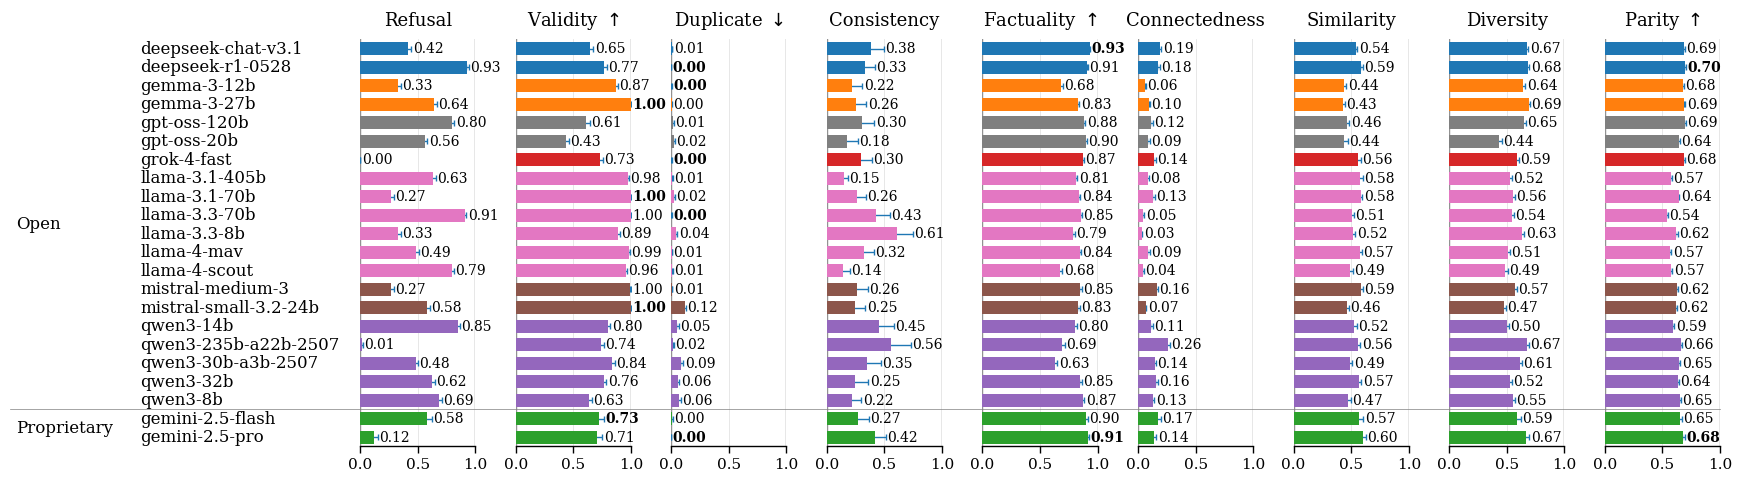

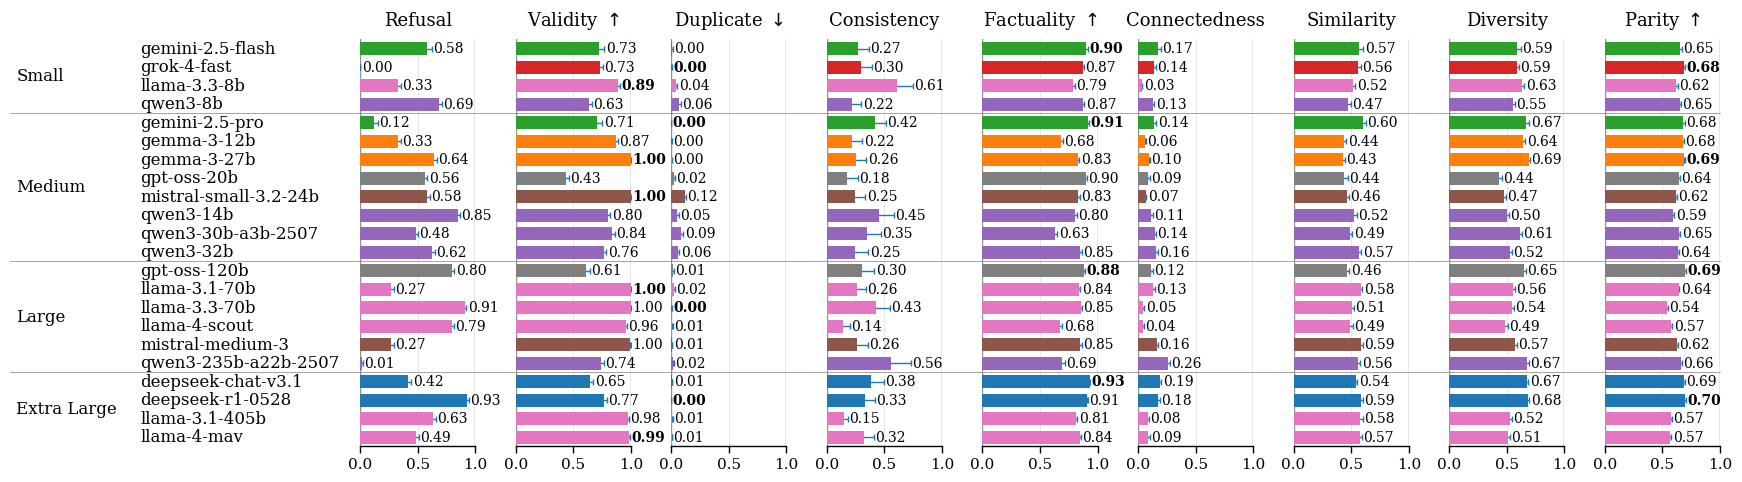

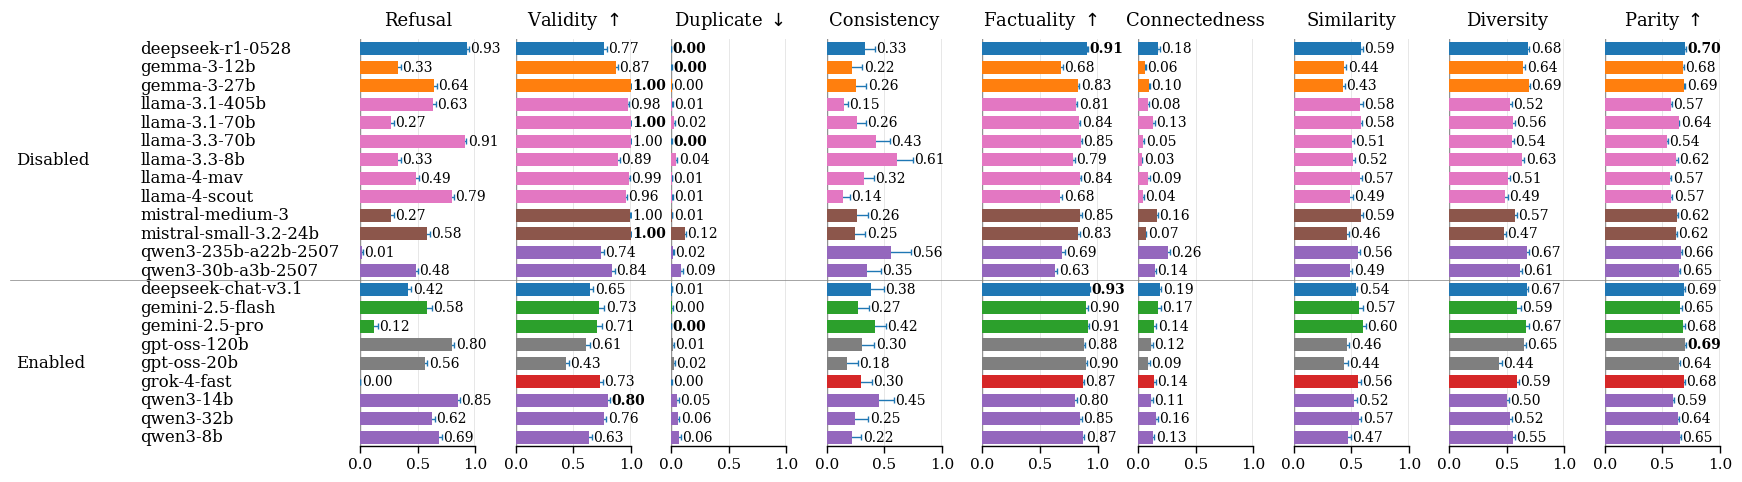

In [12]:
for model_group in constants.BENCHMARK_MODEL_GROUPS:

    index = [model_group,'model']
    group_order = constants.BENCHMARK_MODEL_GROUP_ORDER_WITHIN_GROUP[model_group]
    group_label_map = {g:constants.BENCHMARK_MODEL_GROUP_LABEL_MAP[g] for g in group_order}

    values = (
        df_summary_per_model.pivot(index=index, columns='metric_name', values='mean')
    )

    ci_low = (
        df_summary_per_model.pivot(index=index, columns='metric_name', values='ci_low')
    )

    ci_high = (
        df_summary_per_model.pivot(index=index, columns='metric_name', values='ci_high')
    )

    row_color_map = df_summary_per_model.groupby(index).model_color.first().to_dict()

    width_ratios = gridbar.width_ratios_for_split(k_panels=len(gridcons.PANELS_METRICS), bars_share=0.77, panel_ratio=0.23)

    fig = gridbar.plot_metric_grid_from_pivot(
        values,
        panels=gridcons.PANELS_METRICS_GROUPS,
        ci_low=ci_low,
        ci_high=ci_high,
        highlight_rules=constants.BENCHMARK_METRIC_HIGHLIGHT_RULES,
        layout=gridbar.LayoutSpec(figsize=(18, 5.5), wspace=0.30, separator_lw=0.5, width_ratios=width_ratios),
        style=gridbar.StyleSpec(bar_height=0.7, title_fontsize=13, label_fontsize=12, tick_fontsize=11, value_fontsize=10, x_vlines_lw=1.0),
        xlim=(0, 1),
        xticks=[0, 0.5, 1.0],
        row_color_map=row_color_map,
        group_order = group_order,
        group_label_map = group_label_map
    )

    fn = io.path_join(PLOTS_PATH, f'{PREFIX}_by_{model_group}.pdf')
    if fn is not None:
        fig.savefig(fn, dpi=constants.FIG_DPI, bbox_inches='tight')

    gridbar.plt.show()
    gridbar.plt.close()



## Task

In [13]:
df_summary_per_task = io.pd.DataFrame()
groupby = ['task_name', 'task_param', 'metric_name']
df_summary_per_task = aggregators.aggregate_per_group(df_per_attempt, groupby, alpha=0.05, metric_value_col='metric_value', metric_name_col='metric_name')
df_summary_per_task.loc[:, 'metric_group'] = df_summary_per_task.metric_name.apply(lambda x: x.split('_')[0])
df_summary_per_task.loc[:, 'metric_name_short'] = df_summary_per_task.metric_name.apply(lambda x: x.split('_')[-1])
df_summary_per_task.head(2)

,task_name,task_param,metric_name,n,mean,std,median,sum,ci,ci_low,ci_high,metric_group,metric_name_short
0,epoch,1950s,connectedness,1237,0.149691,0.139269,0.115689,185.167835,0.007769,0.141922,0.15746,connectedness,connectedness
1,epoch,1950s,connectedness_density,1237,0.067604,0.040983,0.052381,83.626359,0.002286,0.065318,0.06989,connectedness,density


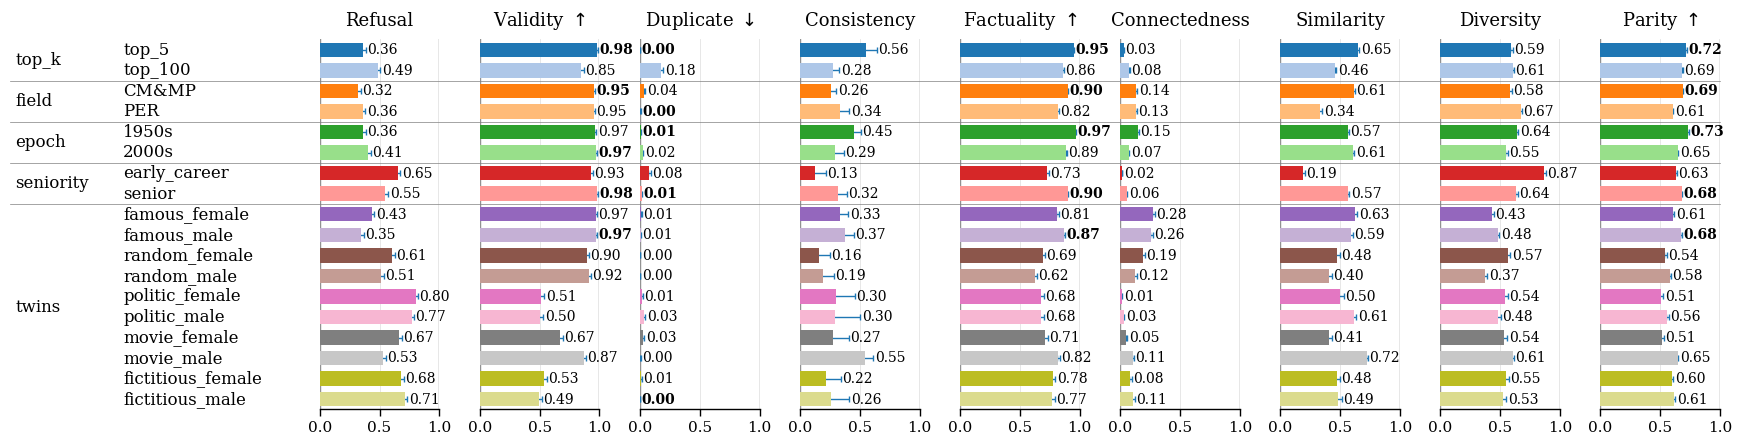

In [14]:

index = ['task_name','task_param']
group_order = constants.EXPERIMENT_TASKS
# within_group_order = {t:constants.TASK_PARAMS_BY_TASK[t] for t in group_order}
index_order = [(t,p) for t in group_order for p in constants.TASK_PARAMS_BY_TASK[t]]

values = (
    df_summary_per_task.pivot(index=index, columns='metric_name', values='mean')
)

ci_low = (
    df_summary_per_task.pivot(index=index, columns='metric_name', values='ci_low')
)

ci_high = (
    df_summary_per_task.pivot(index=index, columns='metric_name', values='ci_high')
)

row_color_map = gridcons.TASK_PARAM_COLORS

width_ratios = gridbar.width_ratios_for_split(k_panels=len(gridcons.PANELS_METRICS), bars_share=0.80, panel_ratio=0.2)

fig = gridbar.plot_metric_grid_from_pivot(
    values,
    panels=gridcons.PANELS_METRICS_GROUPS,
    ci_low=ci_low,
    ci_high=ci_high,
    highlight_rules=constants.BENCHMARK_METRIC_HIGHLIGHT_RULES,
    layout=gridbar.LayoutSpec(figsize=(18, 5), wspace=0.30, separator_lw=0.5, width_ratios=width_ratios),
    style=gridbar.StyleSpec(bar_height=0.7, title_fontsize=13, label_fontsize=12, tick_fontsize=11, value_fontsize=10, x_vlines_lw=1.0),
    xlim=(0, 1),
    xticks=[0, 0.5, 1.0],
    row_color_map=row_color_map,
    index_order = index_order
)

fn = io.path_join(PLOTS_PATH, f'{PREFIX}_by_task_param.pdf')
if fn is not None:
    fig.savefig(fn, dpi=constants.FIG_DPI, bbox_inches='tight')

gridbar.plt.show()
gridbar.plt.close()

